In [ ]:
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score, StratifiedKFold
import numpy as np
import pandas as pd
from sklearn.utils import shuffle
import matplotlib.pyplot as plt

mol = pd.read_csv("/content/drive/My Drive/result.csv")

smiles = mol.drop_duplicates(subset = ['Pubid'], keep='first')
smiles = smiles['Smiles']

<ipython-input-3-8f365d6558a8>:10: DtypeWarning: Columns (10) have mixed types. Specify dtype option on import or set low_memory=False.
  mol = pd.read_csv("/content/drive/My Drive/result.csv")


In [ ]:
import torch
from torch_geometric.data import Data, DataLoader
from deepchem.feat import PagtnMolGraphFeaturizer

wandb: WARNING W&B installed but not logged in.  Run `wandb login` or set the WANDB_API_KEY env variable.
Instructions for updating:
experimental_relax_shapes is deprecated, use reduce_retracing instead
wandb: WARNING W&B installed but not logged in.  Run `wandb login` or set the WANDB_API_KEY env variable.


In [ ]:
from deepchem.feat import PagtnMolGraphFeaturizer

# Initialize the featurizer
featurizer = PagtnMolGraphFeaturizer(max_length=5)

# Apply the featurizer to the SMILES series
featurized_data = featurizer.featurize(smiles.tolist())

from deepchem.feat import PagtnMolGraphFeaturizer
import pandas as pd

# Initialize the featurizer
featurizer = PagtnMolGraphFeaturizer(max_length=5)

# Apply the featurizer to the SMILES series
featurized_data = featurizer.featurize(smiles.tolist())

graphs = []

for i, graph_data in enumerate(featurized_data):
    # Convert node features and edge indices into PyTorch tensors
    x = torch.tensor(graph_data.node_features, dtype=torch.float)  # Node features
    edge_index = torch.tensor(graph_data.edge_index, dtype=torch.long).t().contiguous()  # Edge index

    # Create a PyTorch Geometric Data object
    data = Data(x=x, edge_index=edge_index)

    graphs.append(data)

# Create a DataLoader
loader = DataLoader(graphs, batch_size=32, shuffle=True)

Streaming output truncated to the last 5000 lines.
[09:16:45] DEPRECATION WARNING: please use GetValence(which=)
[09:16:45] DEPRECATION WARNING: please use GetValence(getExplicit=False)
[09:16:45] DEPRECATION WARNING: please use GetValence(which=)
[09:16:45] DEPRECATION WARNING: please use GetValence(getExplicit=False)
[09:16:45] DEPRECATION WARNING: please use GetValence(which=)
[09:16:45] DEPRECATION WARNING: please use GetValence(getExplicit=False)
[09:16:45] DEPRECATION WARNING: please use GetValence(which=)
[09:16:45] DEPRECATION WARNING: please use GetValence(getExplicit=False)
[09:16:45] DEPRECATION WARNING: please use GetValence(which=)
[09:16:45] DEPRECATION WARNING: please use GetValence(getExplicit=False)
[09:16:45] DEPRECATION WARNING: please use GetValence(which=)
[09:16:45] DEPRECATION WARNING: please use GetValence(getExplicit=False)
[09:16:45] DEPRECATION WARNING: please use GetValence(which=)
[09:16:45] DEPRECATION WARNING: please use GetValence(getExplicit=False)
[09:

In [ ]:
mol = pd.read_csv("/content/drive/My Drive/result.csv")

smiles = mol.drop_duplicates(subset = ['Pubid'], keep='first')
smiles = smiles['Smiles']

smiles_counts = mol['Smiles'].value_counts().reset_index()
pd.set_option('display.max_rows', 10)

# Initialize the featurizer
featurizer = PagtnMolGraphFeaturizer(max_length=5)

# Apply the featurizer to the SMILES series
featurized_data = featurizer.featurize(smiles.tolist())

# Initialize the featurizer
featurizer = PagtnMolGraphFeaturizer(max_length=5)

# Apply the featurizer to the SMILES series
featurized_data = featurizer.featurize(smiles.tolist())

results = []

for i, graph_data in enumerate(featurized_data):
    result = {
        "SMILES": smiles.iloc[i],
        "Node Features": graph_data.node_features.tolist(),  # Convert to list for storage
        "Edge Features": graph_data.edge_features.tolist(),   # Convert to list for storage
        "Edge Index": graph_data.edge_index.tolist()         # Convert to list for storage
    }
    results.append(result)

results_df = pd.DataFrame(results)

results_df.to_csv("node_edge_features.csv", index=False)

# Display the results
print(results_df.head(6))

Streaming output truncated to the last 5000 lines.
[09:17:15] DEPRECATION WARNING: please use GetValence(which=)
[09:17:15] DEPRECATION WARNING: please use GetValence(getExplicit=False)
[09:17:15] DEPRECATION WARNING: please use GetValence(which=)
[09:17:15] DEPRECATION WARNING: please use GetValence(getExplicit=False)
[09:17:15] DEPRECATION WARNING: please use GetValence(which=)
[09:17:15] DEPRECATION WARNING: please use GetValence(getExplicit=False)
[09:17:15] DEPRECATION WARNING: please use GetValence(which=)
[09:17:15] DEPRECATION WARNING: please use GetValence(getExplicit=False)
[09:17:15] DEPRECATION WARNING: please use GetValence(which=)
[09:17:15] DEPRECATION WARNING: please use GetValence(getExplicit=False)
[09:17:15] DEPRECATION WARNING: please use GetValence(which=)
[09:17:15] DEPRECATION WARNING: please use GetValence(getExplicit=False)
[09:17:15] DEPRECATION WARNING: please use GetValence(which=)
[09:17:15] DEPRECATION WARNING: please use GetValence(getExplicit=False)
[09:

                                              SMILES  \
0  COC1=CC(C2=CN(C)C(=O)C3=CN=CC=C23)=CC(OC)=C1CN...   
1  COC1=CC(C2=CN(C)C(=O)C3=CN=CC=C23)=C(OC)C=C1CN...   
2  CC/C(=C(\C1=CC=CC=C1)C1=CC=C(OCCN(C)C)C=C1)C1=...   
3  CC1=C(C2=CC=C(O)C=C2)N(CC2=CC=C(OCCN3CCCCCC3)C...   
4  OC1=CC=C2C(=C1)CC[C@H](C1=CC=CC=C1)[C@@H]2C1=C...   
5  CNC(=O)C1=CC=C(N2C(=S)N(C3=CC=C(C#N)C(C(F)(F)F...   

                                       Node Features  \
0  [[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...   
1  [[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...   
2  [[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...   
3  [[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...   
4  [[0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...   
5  [[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...   

                                       Edge Features  \
0  [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...   
1  [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...   
2  [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0

In [ ]:
smiles_counts = mol['Smiles'].value_counts().reset_index()
pd.set_option('display.max_rows', None)

df = pd.merge(results_df, smiles_counts, left_on='SMILES', right_on='Smiles', how = 'left')
(df['count']).describe()

unique_interactions = mol.groupby("Compound ID")["gene_name"].nunique()

# Display results
df_dedup = unique_interactions.reset_index()
df['number_dedup'] = df_dedup['gene_name']
df['count_binned_custom'] = pd.cut(df['number_dedup'], bins=[0, 16, 60.1, 115], labels=[0, 1, 2])

In [ ]:
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from scipy.stats import skew, kurtosis

def aggregate_features1(node_features, edge_features):
    # Node statistics
    node_mean = np.mean(node_features, axis=0)
    node_max = np.max(node_features, axis=0)
    node_min = np.min(node_features, axis=0)
    node_median = np.median(node_features, axis=0)
    node_std = np.std(node_features, axis=0)
    node_skew = skew(node_features, axis=0)
    node_kurtosis = kurtosis(node_features, axis=0)

    # Edge statistics
    edge_mean = np.mean(edge_features, axis=0)
    edge_max = np.max(edge_features, axis=0)
    edge_min = np.min(edge_features, axis=0)
    edge_median = np.median(edge_features, axis=0)
    edge_std = np.std(edge_features, axis=0)
    edge_skew = skew(edge_features, axis=0)
    edge_kurtosis = kurtosis(edge_features, axis=0)

    return np.concatenate([
        node_mean, node_max, node_min, node_median, node_std, node_skew, node_kurtosis,
        edge_mean, edge_max, edge_min, edge_median, edge_std, edge_skew, edge_kurtosis
    ])

def aggregate_features(node_features, edge_features):
    node_mean = np.mean(node_features, axis=0)
    node_max = np.max(node_features, axis=0)
    node_std = np.std(node_features, axis=0)

    edge_mean = np.mean(edge_features, axis=0)
    edge_max = np.max(edge_features, axis=0)
    edge_std = np.std(edge_features, axis=0)

    return np.concatenate([node_mean, node_max, node_std, edge_mean, edge_max, edge_std])

# Apply aggregation to all molecules
df["Features"] = df.apply(lambda row: aggregate_features(row["Node Features"], row["Edge Features"]), axis=1)
X = np.vstack(df["Features"].values)

# Convert list of features into a structured DataFrame
X = np.vstack(df["Features"].values)  # Shape: (num_samples, num_features)
y = df["count_binned_custom"].values  # Target labels

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
X.shape

(172, 408)

In [ ]:
# Shuffle dataset
df = shuffle(df, random_state=42)

# Define Random Forest model
clf = RandomForestClassifier(
    n_estimators=100,  # More trees
    max_depth=200,      # Deeper trees
    min_samples_split=5,  # Reduce overfitting
    class_weight="balanced",  # Handle class imbalance
    random_state=42
)

# Perform 5-fold cross-validation
scores = cross_val_score(clf, X, y, cv=10, scoring="accuracy")

# Print results
print("Cross-validation scores:", scores)
print("Mean accuracy:", scores.mean())
print("Standard deviation:", scores.std())

Cross-validation scores: [0.66666667 0.66666667 0.76470588 0.58823529 0.58823529 0.70588235
 0.70588235 0.70588235 0.70588235 0.70588235]
Mean accuracy: 0.6803921568627451
Standard deviation: 0.052649888557245304


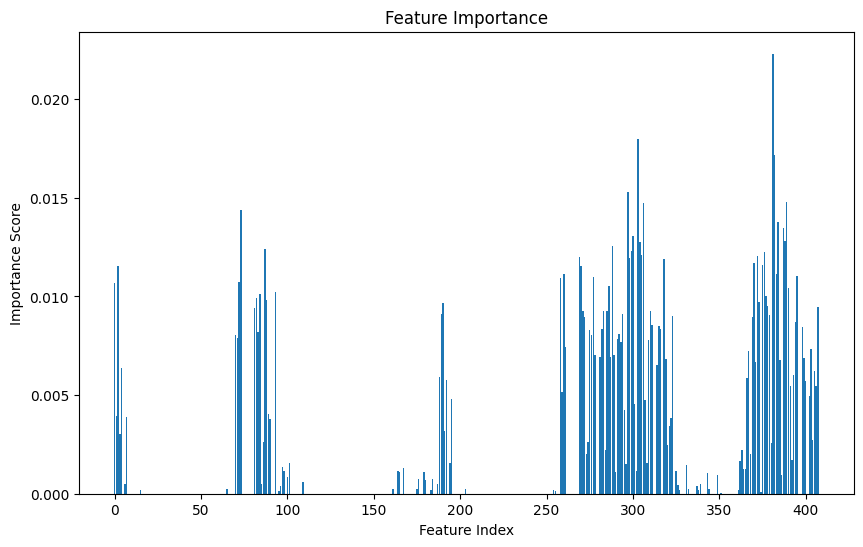

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier

# Train Random Forest
clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X, y)

# Get feature importances
importances = clf.feature_importances_

# # Sort feature importances in descending order
# indices = np.argsort(importances)[::-1]

# Plot feature importances
plt.figure(figsize=(10, 6))
plt.title("Feature Importance")
plt.bar(range(X.shape[1]), importances, align="center")
plt.xlabel("Feature Index")
plt.ylabel("Importance Score")
plt.show()

node_max_importance = 0


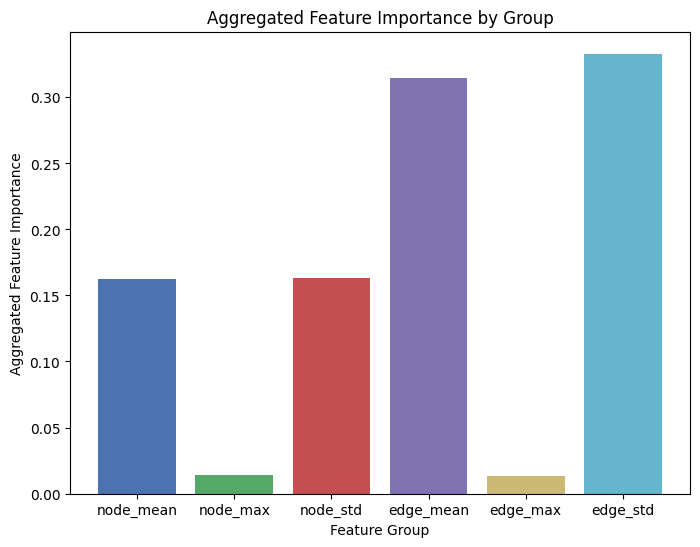

node_mean: 0.1625
node_max: 0.0141
node_std: 0.1629
edge_mean: 0.3142
edge_max: 0.0133
edge_std: 0.3330


In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# -----------------------------------------------------------
# Example: Suppose you already have a trained RandomForest
# and have obtained feature_importances_ of shape (408,).
# Replace the line below with your actual importances.
# -----------------------------------------------------------
feature_importances = importances  # Simulated importances

# Define constants for slicing
NUM_NODE_FEATURES = 94  # node_mean, node_max, node_min each has 94 features
NUM_EDGE_FEATURES = 42  # edge_mean, edge_max, edge_min each has 42 features

# Slicing indices for each group
node_mean_slice = feature_importances[0 : NUM_NODE_FEATURES]
node_max_slice  = feature_importances[NUM_NODE_FEATURES : 2*NUM_NODE_FEATURES]
node_std_slice  = feature_importances[2*NUM_NODE_FEATURES : 3*NUM_NODE_FEATURES]

edge_mean_slice = feature_importances[3*NUM_NODE_FEATURES : 3*NUM_NODE_FEATURES + NUM_EDGE_FEATURES]
edge_max_slice  = feature_importances[3*NUM_NODE_FEATURES + NUM_EDGE_FEATURES : 3*NUM_NODE_FEATURES + 2*NUM_EDGE_FEATURES]
edge_std_slice  = feature_importances[3*NUM_NODE_FEATURES + 2*NUM_EDGE_FEATURES : 3*NUM_NODE_FEATURES + 3*NUM_EDGE_FEATURES]

# Sum the importances within each group
node_mean_imp = node_mean_slice.sum()
node_max_imp  = node_max_slice.sum()
node_std_imp  = node_std_slice.sum()
edge_mean_imp = edge_mean_slice.sum()
edge_max_imp  = edge_max_slice.sum()
edge_std_imp  = edge_std_slice.sum()

# Prepare data for plotting
groups = ["node_mean", "node_max", "node_std", "edge_mean", "edge_max", "edge_std"]
importances_aggregated = [
    node_mean_imp,
    node_max_imp,
    node_std_imp,
    edge_mean_imp,
    edge_max_imp,
    edge_std_imp
]

# Plot the aggregated feature importances
plt.figure(figsize=(8, 6))
plt.bar(groups, importances_aggregated, color=["#4C72B0", "#55A868", "#C44E52", "#8172B2", "#CCB974", "#64B5CD"])
plt.xlabel("Feature Group")
plt.ylabel("Aggregated Feature Importance")
plt.title("Aggregated Feature Importance by Group")
plt.show()

# Print numeric values
for grp, val in zip(groups, importances_aggregated):
    print(f"{grp}: {val:.4f}")

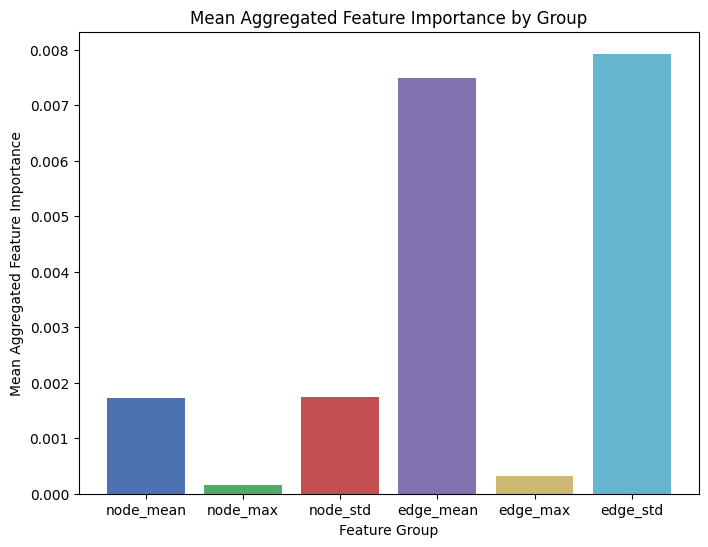

node_mean: 0.0017
node_max: 0.0001
node_std: 0.0017
edge_mean: 0.0075
edge_max: 0.0003
edge_std: 0.0079


In [ ]:
groups = ["node_mean", "node_max", "node_std", "edge_mean", "edge_max", "edge_std"]
importances_aggregated = [
    node_mean_imp/94,
    node_max_imp/94,
    node_std_imp/94,
    edge_mean_imp/42,
    edge_max_imp/42,
    edge_std_imp/42
]

# Plot the aggregated feature importances
plt.figure(figsize=(8, 6))
plt.bar(groups, importances_aggregated, color=["#4C72B0", "#55A868", "#C44E52", "#8172B2", "#CCB974", "#64B5CD"])
plt.xlabel("Feature Group")
plt.ylabel("Mean Aggregated Feature Importance")
plt.title("Mean Aggregated Feature Importance by Group")
plt.show()

# Print numeric values
for grp, val in zip(groups, importances_aggregated):
    print(f"{grp}: {val:.4f}")

## Secondly more features to see

In [ ]:
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from scipy.stats import skew, kurtosis

def aggregate_features1(node_features, edge_features):
    # Node statistics
    node_mean = np.mean(node_features, axis=0)
    node_max = np.max(node_features, axis=0)
    node_min = np.min(node_features, axis=0)
    node_median = np.median(node_features, axis=0)
    node_std = np.std(node_features, axis=0)
    node_skew = skew(node_features, axis=0)
    node_kurtosis = kurtosis(node_features, axis=0)

    # Edge statistics
    edge_mean = np.mean(edge_features, axis=0)
    edge_max = np.max(edge_features, axis=0)
    edge_min = np.min(edge_features, axis=0)
    edge_median = np.median(edge_features, axis=0)
    edge_std = np.std(edge_features, axis=0)
    edge_skew = skew(edge_features, axis=0)
    edge_kurtosis = kurtosis(edge_features, axis=0)

    return np.concatenate([
        node_mean, node_max, node_min, node_median, node_std, node_skew, node_kurtosis,
        edge_mean, edge_max, edge_min, edge_median, edge_std, edge_skew, edge_kurtosis
    ])

# Apply aggregation to all molecules
df["Features1"] = df.apply(lambda row: aggregate_features1(row["Node Features"], row["Edge Features"]), axis=1)
X = np.vstack(df["Features1"].values)

# Convert list of features into a structured DataFrame
X = np.vstack(df["Features1"].values)  # Shape: (num_samples, num_features)
y = df["count_binned_custom"].values  # Target labels

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

<ipython-input-18-30db4d8d8cc9>:15: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  node_skew = skew(node_features, axis=0)
<ipython-input-18-30db4d8d8cc9>:16: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  node_kurtosis = kurtosis(node_features, axis=0)


Cross-validation scores: [0.72222222 0.66666667 0.76470588 0.70588235 0.70588235 0.70588235
 0.70588235 0.70588235 0.70588235 0.58823529]
Mean accuracy: 0.6977124183006536
Standard deviation: 0.04293998267358991


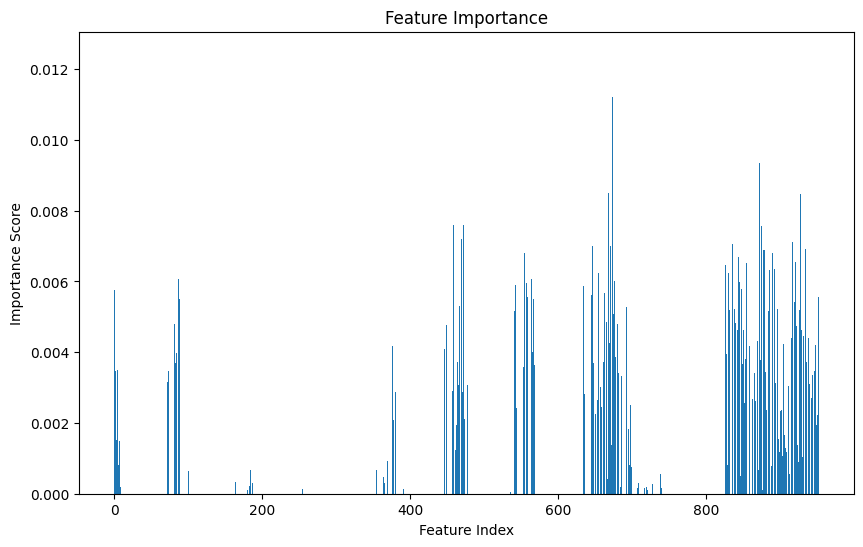

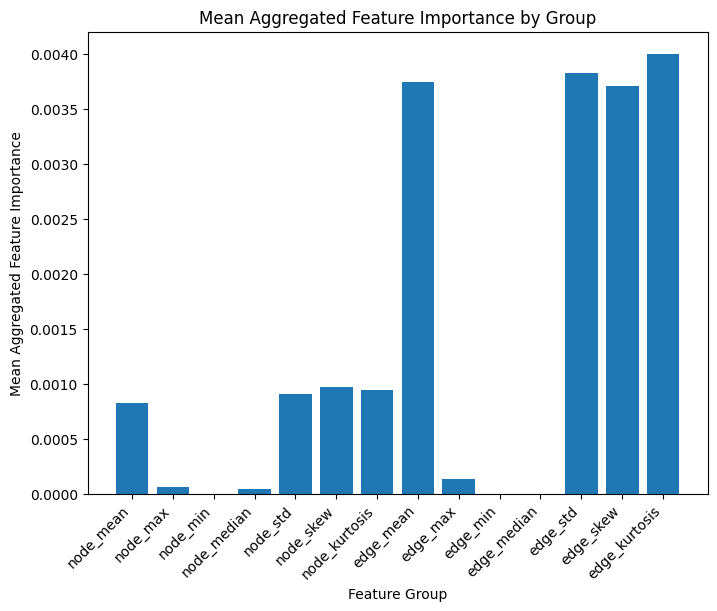

node_mean: 0.0008
node_max: 0.0001
node_min: 0.0000
node_median: 0.0000
node_std: 0.0009
node_skew: 0.0010
node_kurtosis: 0.0009
edge_mean: 0.0037
edge_max: 0.0001
edge_min: 0.0000
edge_median: 0.0000
edge_std: 0.0038
edge_skew: 0.0037
edge_kurtosis: 0.0040


In [ ]:
# Shuffle dataset
df = shuffle(df, random_state=42)

# Define Random Forest model
clf = RandomForestClassifier(
    n_estimators=100,  # More trees
    max_depth=200,      # Deeper trees
    min_samples_split=5,  # Reduce overfitting
    class_weight="balanced",  # Handle class imbalance
    random_state=42
)

# Perform 5-fold cross-validation
scores = cross_val_score(clf, X, y, cv=10, scoring="accuracy")

# Print results
print("Cross-validation scores:", scores)
print("Mean accuracy:", scores.mean())
print("Standard deviation:", scores.std())

clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X, y)

# Get feature importances
importances = clf.feature_importances_

# # Sort feature importances in descending order
# indices = np.argsort(importances)[::-1]

# Plot feature importances
plt.figure(figsize=(10, 6))
plt.title("Feature Importance")
plt.bar(range(X.shape[1]), importances, align="center")
plt.xlabel("Feature Index")
plt.ylabel("Importance Score")
plt.show()

feature_importances = importances  # Simulated importances

# Define constants for slicing
NUM_NODE_FEATURES = 94  # node_mean, node_max, node_min each has 94 features
NUM_EDGE_FEATURES = 42  # edge_mean, edge_max, edge_min each has 42 features

# Slicing indices for each group
node_mean_slice = feature_importances[0 : NUM_NODE_FEATURES]
node_max_slice  = feature_importances[NUM_NODE_FEATURES : 2*NUM_NODE_FEATURES]
node_min_slice  = feature_importances[2*NUM_NODE_FEATURES : 3*NUM_NODE_FEATURES]
node_median_slice = feature_importances[3*NUM_NODE_FEATURES : 4*NUM_NODE_FEATURES]
node_std_slice  = feature_importances[4*NUM_NODE_FEATURES : 5*NUM_NODE_FEATURES]
node_skew_slice = feature_importances[5*NUM_NODE_FEATURES : 6*NUM_NODE_FEATURES]
node_kurtosis_slice = feature_importances[6*NUM_NODE_FEATURES : 7*NUM_NODE_FEATURES]

edge_mean_slice = feature_importances[7*NUM_NODE_FEATURES : 7*NUM_NODE_FEATURES + NUM_EDGE_FEATURES]
edge_max_slice  = feature_importances[7*NUM_NODE_FEATURES + NUM_EDGE_FEATURES : 7*NUM_NODE_FEATURES + 2*NUM_EDGE_FEATURES]
edge_min_slice  = feature_importances[7*NUM_NODE_FEATURES + 2*NUM_EDGE_FEATURES : 7*NUM_NODE_FEATURES + 3*NUM_EDGE_FEATURES]
edge_median_slice = feature_importances[7*NUM_NODE_FEATURES + 3*NUM_EDGE_FEATURES : 7*NUM_NODE_FEATURES + 4*NUM_EDGE_FEATURES]
edge_std_slice  = feature_importances[7*NUM_NODE_FEATURES + 4*NUM_EDGE_FEATURES : 7*NUM_NODE_FEATURES + 5*NUM_EDGE_FEATURES]
edge_skew_slice = feature_importances[7*NUM_NODE_FEATURES + 5*NUM_EDGE_FEATURES : 7*NUM_NODE_FEATURES + 6*NUM_EDGE_FEATURES]
edge_kurtosis_slice = feature_importances[7*NUM_NODE_FEATURES + 6*NUM_EDGE_FEATURES : 7*NUM_NODE_FEATURES + 7*NUM_EDGE_FEATURES]

# Sum the importances within each group
node_mean_imp = node_mean_slice.sum()
node_max_imp  = node_max_slice.sum()
node_min_imp  = node_min_slice.sum()
node_median_imp = node_median_slice.sum()
node_std_imp  = node_std_slice.sum()
node_skew_imp = node_skew_slice.sum()
node_kurtosis_imp = node_kurtosis_slice.sum()

edge_mean_imp = edge_mean_slice.sum()
edge_max_imp  = edge_max_slice.sum()
edge_min_imp  = edge_min_slice.sum()
edge_median_imp = edge_median_slice.sum()
edge_std_imp  = edge_std_slice.sum()
edge_skew_imp = edge_skew_slice.sum()
edge_kurtosis_imp = edge_kurtosis_slice.sum()

import matplotlib.pyplot as plt

groups = ["node_mean", "node_max", "node_min", "node_median", "node_std", "node_skew", "node_kurtosis", "edge_mean", "edge_max", "edge_min", "edge_median", "edge_std", "edge_skew", "edge_kurtosis"]
importances_aggregated = [
    node_mean_imp/94,
    node_max_imp/94,
    node_min_imp/94,
    node_median_imp/94,
    node_std_imp/94,
    node_skew_imp/94,
    node_kurtosis_imp/94,
    edge_mean_imp/42,
    edge_max_imp/42,
    edge_min_imp/42,
    edge_median_imp/42,
    edge_std_imp/42,
    edge_skew_imp/42,
    edge_kurtosis_imp/42
]

# Plot the aggregated feature importances
plt.figure(figsize=(8, 6))
plt.bar(groups, importances_aggregated)
plt.xlabel("Feature Group")
plt.ylabel("Mean Aggregated Feature Importance")
plt.title("Mean Aggregated Feature Importance by Group")

# Rotate the x-labels for better readability
plt.xticks(rotation=45, ha='right')

plt.show()

# Print numeric values
for grp, val in zip(groups, importances_aggregated):
    print(f"{grp}: {val:.4f}")

##Final decision

In [ ]:
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from scipy.stats import skew, kurtosis

def aggregate_features1(node_features, edge_features):
    # Node statistics
    node_mean = np.mean(node_features, axis=0)
    node_std = np.std(node_features, axis=0)
    node_skew = skew(node_features, axis=0)
    node_kurtosis = kurtosis(node_features, axis=0)
    # node_max = np.max(node_features, axis=0)

    # Edge statistics
    edge_mean = np.mean(edge_features, axis=0)
    edge_std = np.std(edge_features, axis=0)
    edge_skew = skew(edge_features, axis=0)
    edge_kurtosis = kurtosis(edge_features, axis=0)
    # edge_max = np.max(edge_features, axis=0)

    return np.concatenate([
        node_mean,
        node_std,
        node_skew,
        node_kurtosis,
        edge_mean,
        edge_std,
        edge_skew,
        edge_kurtosis
    ])

# Apply aggregation to all molecules
df["Features5"] = df.apply(lambda row: aggregate_features1(row["Node Features"], row["Edge Features"]), axis=1)
X = np.vstack(df["Features5"].values)

# Convert list of features into a structured DataFrame
X = np.vstack(df["Features5"].values)  # Shape: (num_samples, num_features)
y = df["count_binned_custom"].values  # Target labels

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

<ipython-input-20-a03d3f6bf4d8>:12: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  node_skew = skew(node_features, axis=0)
<ipython-input-20-a03d3f6bf4d8>:13: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  node_kurtosis = kurtosis(node_features, axis=0)


In [ ]:
X = np.vstack(df["Features5"].values)  # Shape: (num_samples, num_features)
df = shuffle(df, random_state=42)
df['count_binned_custom'] = pd.cut(df['number_dedup'], bins=[0, 18, 60, 115], labels=[0, 1, 2])
y = df['count_binned_custom']

# Define Random Forest model
clf = RandomForestClassifier(
    n_estimators=100,  # More trees
    max_depth=200,      # Deeper trees
    min_samples_split=5,  # Reduce overfitting
    class_weight="balanced",  # Handle class imbalance
    random_state=42
)

# Perform 5-fold cross-validation
scores = cross_val_score(clf, X, y, cv=10, scoring="accuracy")

# Print results
print("Cross-validation scores:", scores)
print("Mean accuracy:", scores.mean())
print("Standard deviation:", scores.std())

Cross-validation scores: [0.8125 0.8125 0.8125 0.8125 0.8125 0.8125 0.8125 0.8125 0.8125 0.8125]
Mean accuracy: 0.8125
Standard deviation: 0.0


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.utils import shuffle

# Shuffle and clean data
df = shuffle(df, random_state=42)
df['count_binned_custom'] = pd.cut(df['number_dedup'], bins=[0, 16, 60.1, 115], labels=[0, 1, 2]).astype(int)

y = df["count_binned_custom"].values

numeric_columns = ['Exact Mass', 'XLogP3', 'Heavy Atom Count', 'Ring Count',
                   'Hydrogen Bond Acceptor Count', 'Hydrogen Bond Donor Count',
                   'Rotatable Bond Count', 'Topological Polar Surface Area']

additional_columns = []

# Combine the selected columns with the "Features" (fingerprints) to form the input data (X)
df_combined = new_df[numeric_columns + additional_columns].copy()
df_combined = df_combined.astype(float)

# Ensure that 'Features' contains the fingerprint data and combine it
X = np.vstack(df["Features5"].values)  # Features from RDKit or other representation
X_combined = np.hstack((df_combined.values, X))  # Combine the features

X_all = np.hstack((X_combined, fingerprints))
X_all = np.nan_to_num(X_all)
# Models
models = {
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42),
    "MLP": MLPClassifier(hidden_layer_sizes=(100,), max_iter=300, random_state=42),
    "Logistic Regression": LogisticRegression(max_iter=500, random_state=42),
    "SVM": SVC(kernel="rbf", probability=True, random_state=42),
    "Gradient Boosting": GradientBoostingClassifier(n_estimators=100, random_state=42)
}

# Accuracy evaluation
def compute_cv_accuracy(X, y, clf):
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    X_clean = np.nan_to_num(X)  # Ensure no NaNs
    return np.mean(cross_val_score(clf, X, y, cv=skf, scoring='accuracy'))

def compute_cv_auc(X, y_bin, clf):
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    y_proba = cross_val_predict(clf, X, y, cv=skf, method='predict_proba')
    return roc_auc_score(y_bin, y_proba, average="macro", multi_class="ovr")

# Feature index helpers
fp_len = len(fingerprints[0])
node_dim = 94 * 4
edge_dim = 42 * 4

# Run ablation per model
for model_name, clf in models.items():
    acc_values = []

    # Baseline
    acc_values.append(compute_cv_accuracy(X_all, y, clf))

    # Remove Fingerprints
    X_no_fp = np.delete(X_all, np.s_[-fp_len:], axis=1)
    acc_values.append(compute_cv_accuracy(X_no_fp, y, clf))

    # Remove Exact Mass
    X_ablated = np.delete(X_no_fp, 0, axis=1)
    acc_values.append(compute_cv_accuracy(X_ablated, y, clf))

    # Remove XLogP3
    X_ablated = np.delete(X_ablated, 0, axis=1)
    acc_values.append(compute_cv_accuracy(X_ablated, y, clf))

    # Remove Ring Count (index 3 in your numeric list)
    X_ablated = np.delete(X_ablated, 1, axis=1)
    acc_values.append(compute_cv_accuracy(X_ablated, y, clf))

    # Remove PAGTN Edge Features
    X_ablated = np.delete(X_ablated, np.s_[- edge_dim:], axis=1)
    acc_values.append(compute_cv_accuracy(X_ablated, y, clf))

    # Remove PAGTN Node Features
    X_ablated = np.delete(X_ablated, np.s_[-node_dim:], axis=1)
    acc_values.append(compute_cv_accuracy(X_ablated, y, clf))

    # Remove Hydrogen Bond Acceptor Count (index 4)
    X_ablated = np.delete(X_ablated, 1, axis=1)
    acc_values.append(compute_cv_accuracy(X_ablated, y, clf))

    # Remove Hydrogen Bond Donor Count (index 5)
    X_ablated = np.delete(X_ablated, 1, axis=1)
    acc_values.append(compute_cv_accuracy(X_ablated, y, clf))

    # Remove Rotatable Bonds (index 6)
    X_ablated = np.delete(X_ablated, 1, axis=1)
    acc_values.append(compute_cv_accuracy(X_ablated, y, clf))

    # Labels in specified order
    labels = [
        "Baseline",
        "Remove Fingerprint",
        "Remove Exact Mass",
        "Remove XLogP3",
        "Remove Ring Count",
        "Remove PAGTN Edge Feature",
        "Remove PAGTN Node Feature",
        'Remove Hydrogen Bond Acceptor Count',
        'Remove Hydrogen Bond Donor Count',
        "Remove Rotatable Bonds"
    ]

    # Plot
    plt.figure(figsize=(12, 6))
    plt.barh(labels[::-1], acc_values[::-1], color='skyblue')
    plt.xlabel("Accuracy After Feature Removal")
    plt.ylabel("Feature Removed")
    plt.title(f"Ablation Study - {model_name}")
    plt.tight_layout()
    plt.grid(axis='x', linestyle='--', alpha=0.6)
    plt.show()


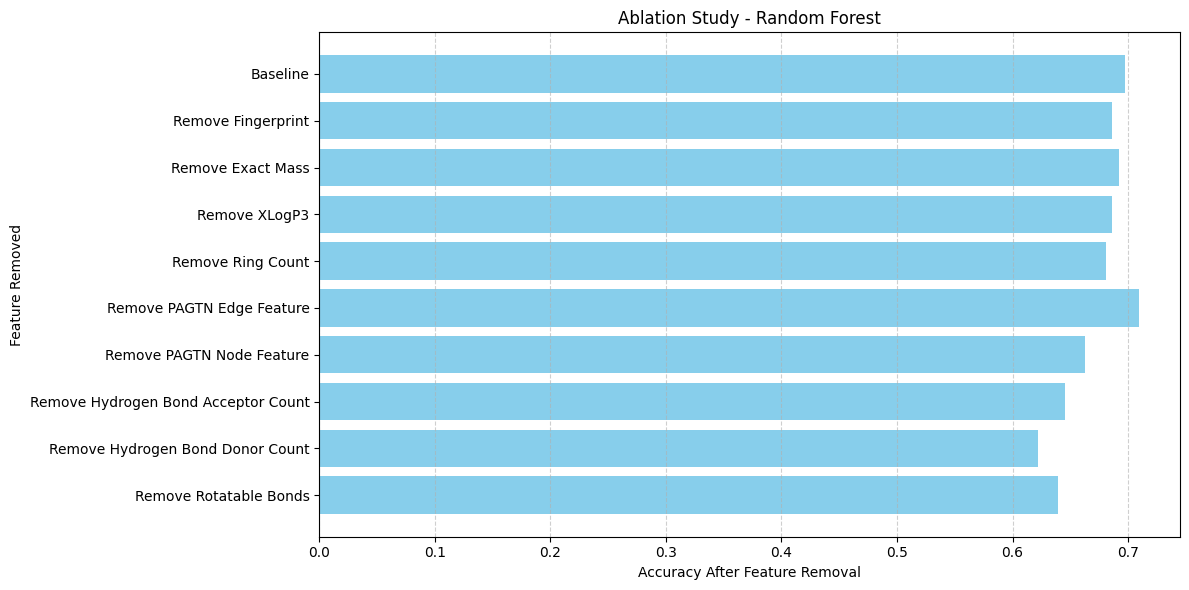

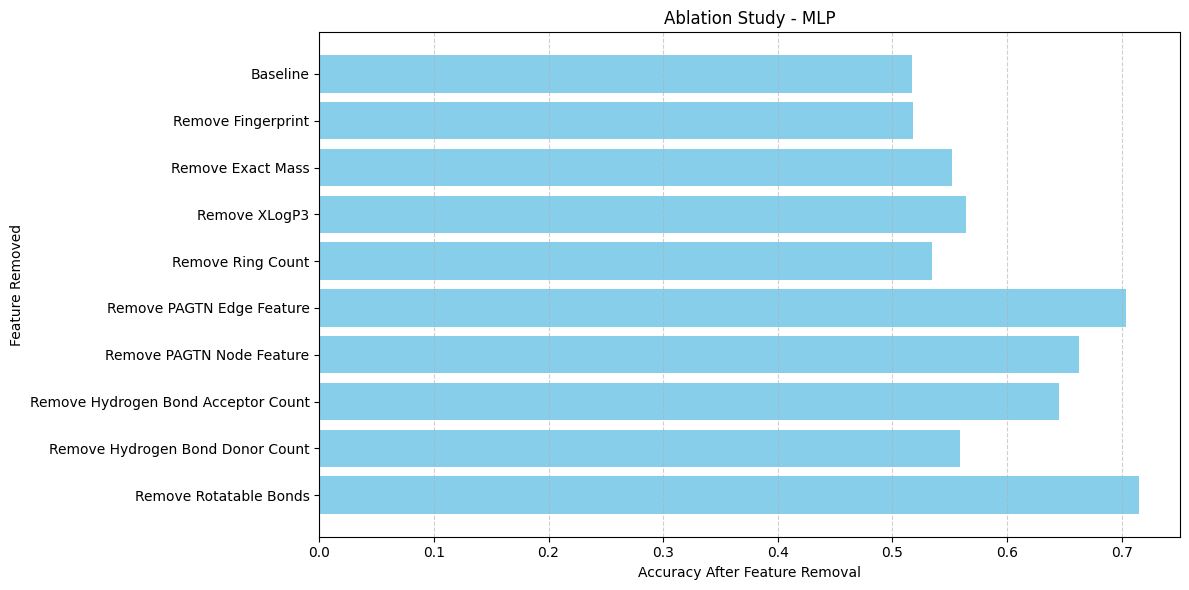

/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

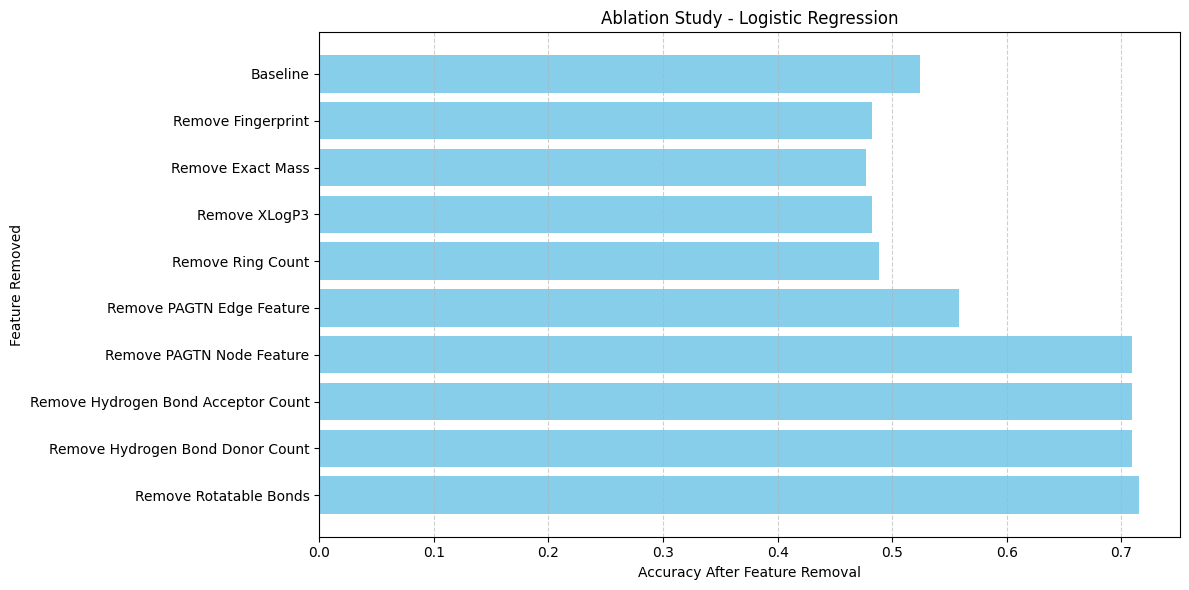

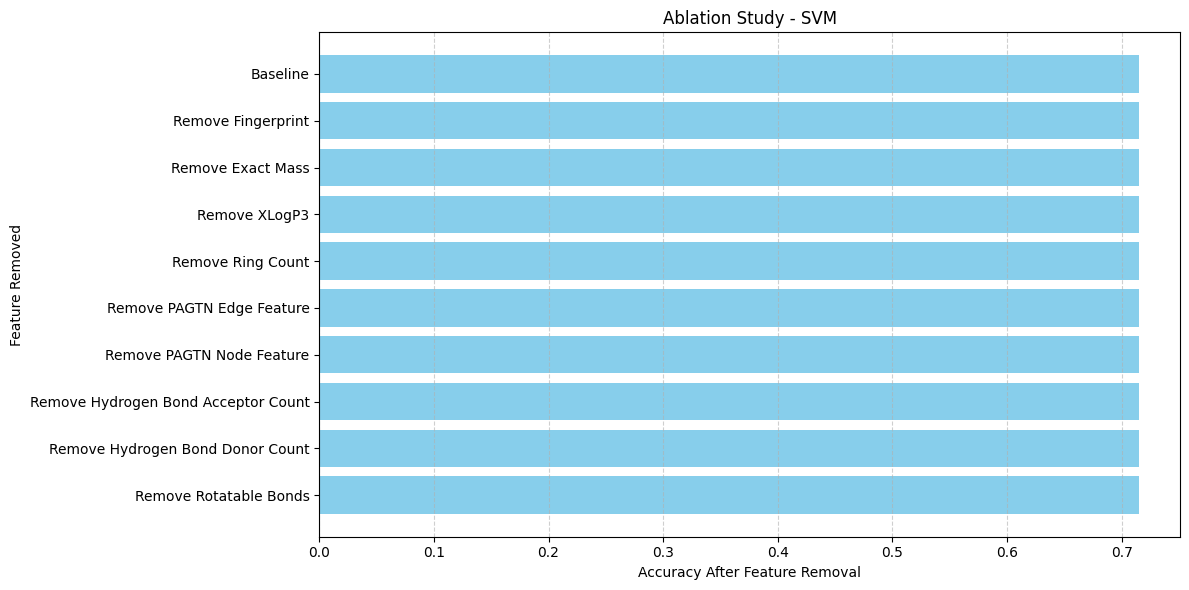

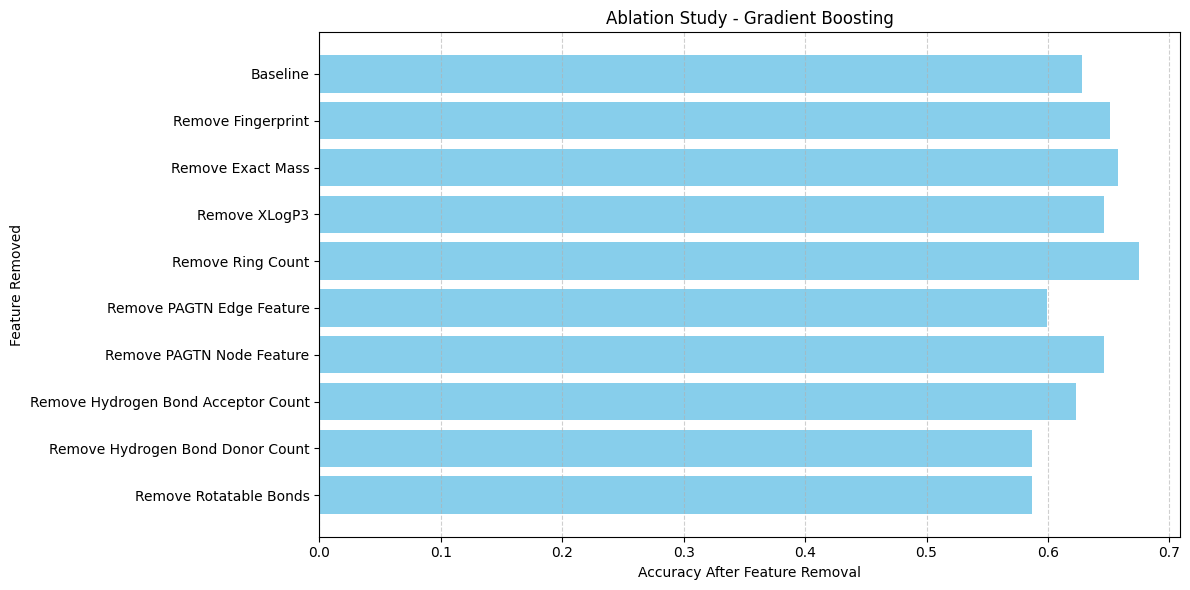

Ablation results saved to 'ablation_results_table.csv' and JSON.


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import json
from collections import defaultdict

from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.utils import shuffle

# Shuffle and clean data
df = shuffle(df, random_state=42)
y = df["count_binned_custom"].values

numeric_columns = ['Exact Mass', 'XLogP3', 'Heavy Atom Count', 'Ring Count',
                   'Hydrogen Bond Acceptor Count', 'Hydrogen Bond Donor Count',
                   'Rotatable Bond Count', 'Topological Polar Surface Area']

additional_columns = []

# Combine selected columns with fingerprints
df_combined = new_df[numeric_columns + additional_columns].copy().astype(float)
X = np.vstack(df["Features5"].values)
X_combined = np.hstack((df_combined.values, X))

X_all = np.hstack((X_combined, fingerprints))
X_all = np.nan_to_num(X_all)

# Models
models = {
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42),
    "MLP": MLPClassifier(hidden_layer_sizes=(100,), max_iter=300, random_state=42),
    "Logistic Regression": LogisticRegression(max_iter=500, random_state=42),
    "SVM": SVC(kernel="rbf", probability=True, random_state=42),
    "Gradient Boosting": GradientBoostingClassifier(n_estimators=100, random_state=42)
}

# Evaluation function
def compute_cv_accuracy(X, y, clf):
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    X_clean = np.nan_to_num(X)
    return np.mean(cross_val_score(clf, X_clean, y, cv=skf, scoring='accuracy'))

# Feature dimensions
fp_len = len(fingerprints[0])
node_dim = 94 * 4
edge_dim = 42 * 4

# Labels for ablation steps
labels = [
    "Baseline",
    "Remove Fingerprint",
    "Remove Exact Mass",
    "Remove XLogP3",
    "Remove Ring Count",
    "Remove PAGTN Edge Feature",
    "Remove PAGTN Node Feature",
    'Remove Hydrogen Bond Acceptor Count',
    'Remove Hydrogen Bond Donor Count',
    "Remove Rotatable Bonds"
]

# Store results: rows = ablation, columns = model names
ablation_results = defaultdict(list)

# Ablation loop
for model_name, clf in models.items():
    acc_values = []

    # Baseline
    acc_values.append(compute_cv_accuracy(X_all, y, clf))

    # Remove Fingerprints
    X_step = np.delete(X_all, np.s_[-fp_len:], axis=1)
    acc_values.append(compute_cv_accuracy(X_step, y, clf))

    # Remove Exact Mass
    X_step = np.delete(X_step, 0, axis=1)
    acc_values.append(compute_cv_accuracy(X_step, y, clf))

    # Remove XLogP3
    X_step = np.delete(X_step, 0, axis=1)
    acc_values.append(compute_cv_accuracy(X_step, y, clf))

    # Remove Ring Count (original index 3 in numeric list)
    X_step = np.delete(X_step, 1, axis=1)
    acc_values.append(compute_cv_accuracy(X_step, y, clf))

    # Remove PAGTN Edge Features
    X_step = np.delete(X_step, np.s_[-edge_dim:], axis=1)
    acc_values.append(compute_cv_accuracy(X_step, y, clf))

    # Remove PAGTN Node Features
    X_step = np.delete(X_step, np.s_[-node_dim:], axis=1)
    acc_values.append(compute_cv_accuracy(X_step, y, clf))

    # Remove Hydrogen Bond Acceptor Count
    X_step = np.delete(X_step, 1, axis=1)
    acc_values.append(compute_cv_accuracy(X_step, y, clf))

    # Remove Hydrogen Bond Donor Count
    X_step = np.delete(X_step, 1, axis=1)
    acc_values.append(compute_cv_accuracy(X_step, y, clf))

    # Remove Rotatable Bonds
    X_step = np.delete(X_step, 1, axis=1)
    acc_values.append(compute_cv_accuracy(X_step, y, clf))

    # Store results
    for label, acc in zip(labels, acc_values):
        ablation_results[label].append(acc)

    # Optional: plot
    plt.figure(figsize=(12, 6))
    plt.barh(labels[::-1], acc_values[::-1], color='skyblue')
    plt.xlabel("Accuracy After Feature Removal")
    plt.ylabel("Feature Removed")
    plt.title(f"Ablation Study - {model_name}")
    plt.tight_layout()
    plt.grid(axis='x', linestyle='--', alpha=0.6)
    plt.show()

# Convert to DataFrame
ablation_df = pd.DataFrame(ablation_results, index=models.keys()).T

# Save to CSV
ablation_df.to_csv("ablation_results_table.csv")

# Optional: also save to JSON
with open("ablation_results_table.json", "w") as f:
    json.dump(ablation_results, f, indent=4)

print("Ablation results saved to 'ablation_results_table.csv' and JSON.")

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.utils import shuffle
from collections import defaultdict

# Collect results by ablation (row = ablation step, col = model name)
ablation_results = defaultdict(list)

# Shuffle and clean data
df = shuffle(df, random_state=42)
y = df["count_binned_custom"].values

numeric_columns = ['Exact Mass', 'XLogP3', 'Heavy Atom Count', 'Ring Count',
                   'Hydrogen Bond Acceptor Count', 'Hydrogen Bond Donor Count',
                   'Rotatable Bond Count', 'Topological Polar Surface Area']

additional_columns = []

# Combine the selected columns with the "Features" (fingerprints) to form the input data (X)
df_combined = new_df[numeric_columns + additional_columns].copy()
df_combined = df_combined.astype(float)

# Ensure that 'Features' contains the fingerprint data and combine it
X = np.vstack(df["Features5"].values)  # Features from RDKit or other representation
X_combined = np.hstack((df_combined.values, X))  # Combine the features

X_all = np.hstack((X_combined, fingerprints))
X_all = np.nan_to_num(X_all)
# Models
models = {
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42),
    "MLP": MLPClassifier(hidden_layer_sizes=(100,), max_iter=300, random_state=42),
    "Logistic Regression": LogisticRegression(max_iter=500, random_state=42),
    "SVM": SVC(kernel="rbf", probability=True, random_state=42),
    "Gradient Boosting": GradientBoostingClassifier(n_estimators=100, random_state=42)
}

# Accuracy evaluation
def compute_cv_accuracy(X, y, clf):
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    X_clean = np.nan_to_num(X)  # Ensure no NaNs
    return np.mean(cross_val_score(clf, X, y, cv=skf, scoring='accuracy'))

def compute_cv_auc(X, y_bin, clf):
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    y_proba = cross_val_predict(clf, X, y, cv=skf, method='predict_proba')
    return roc_auc_score(y_bin, y_proba, average="macro", multi_class="ovr")

# Feature index helpers
fp_len = len(fingerprints[0])
node_dim = 94 * 4
edge_dim = 42 * 4

# Run ablation per model
for model_name, clf in models.items():
    acc_values = []

    # Baseline
    acc_values.append(compute_cv_accuracy(X_all, y, clf))

    # Remove Fingerprints
    X_no_fp = np.delete(X_all, np.s_[-fp_len:], axis=1)
    acc_values.append(compute_cv_accuracy(X_no_fp, y, clf))

    # Remove Exact Mass
    X_ablated = np.delete(X_no_fp, 0, axis=1)
    acc_values.append(compute_cv_accuracy(X_ablated, y, clf))

    # Remove XLogP3
    X_ablated = np.delete(X_ablated, 0, axis=1)
    acc_values.append(compute_cv_accuracy(X_ablated, y, clf))

    # Remove Ring Count (index 3 in your numeric list)
    X_ablated = np.delete(X_ablated, 1, axis=1)
    acc_values.append(compute_cv_accuracy(X_ablated, y, clf))

    # Remove PAGTN Edge Features
    X_ablated = np.delete(X_ablated, np.s_[- edge_dim:], axis=1)
    acc_values.append(compute_cv_accuracy(X_ablated, y, clf))

    # Remove PAGTN Node Features
    X_ablated = np.delete(X_ablated, np.s_[-node_dim:], axis=1)
    acc_values.append(compute_cv_accuracy(X_ablated, y, clf))

    # Remove Hydrogen Bond Acceptor Count (index 4)
    X_ablated = np.delete(X_ablated, 1, axis=1)
    acc_values.append(compute_cv_accuracy(X_ablated, y, clf))

    # Remove Hydrogen Bond Donor Count (index 5)
    X_ablated = np.delete(X_ablated, 1, axis=1)
    acc_values.append(compute_cv_accuracy(X_ablated, y, clf))

    # Remove Rotatable Bonds (index 6)
    X_ablated = np.delete(X_ablated, 1, axis=1)
    acc_values.append(compute_cv_accuracy(X_ablated, y, clf))

    # Labels in specified order
    labels = [
        "Baseline",
        "Remove Fingerprint",
        "Remove Exact Mass",
        "Remove XLogP3",
        "Remove Ring Count",
        "Remove PAGTN Edge Feature",
        "Remove PAGTN Node Feature",
        'Remove Hydrogen Bond Acceptor Count',
        'Remove Hydrogen Bond Donor Count',
        "Remove Rotatable Bonds"
    ]

    # Plot
    plt.figure(figsize=(12, 6))
    plt.barh(labels[::-1], acc_values[::-1], color='skyblue')
    plt.xlabel("Accuracy After Feature Removal")
    plt.ylabel("Feature Removed")
    plt.title(f"Ablation Study - {model_name}")
    plt.tight_layout()
    plt.grid(axis='x', linestyle='--', alpha=0.6)
    plt.show()


In [ ]:
# Accuracy after removing features
acc_values = []
X_ablated = X_all.copy()

# Remove fingerprints
X_ablated_fingerprints = np.delete(X_ablated, np.s_[-len(fingerprints[0]):], axis=1)
acc_values.append(compute_cv_accuracy(X_ablated_fingerprints, y, clf))  # 0: Fingerprints

# Accuracy after removing each numeric feature one by one
for i in range(len(numeric_columns)):
    X_temp = np.delete(X_all, i, axis=1)
    acc_values.append(compute_cv_accuracy(X_temp, y, clf))  # 1~6: Each numeric feature

# Remove node features (assumes they are first 94*4 columns in Features5)
X_ablated_node = np.delete(X_ablated_fingerprints, np.s_[:94*4], axis=1)
acc_values.insert(3, compute_cv_accuracy(X_ablated_node, y, clf))  # 3: Node Features

# Remove edge features (assumes they are last 42*4 columns in Features5)
X_ablated_edge = np.delete(X_ablated_node, np.s_[-42*4:], axis=1)
acc_values.insert(4, compute_cv_accuracy(X_ablated_edge, y, clf))  # 4: Edge Features

# Labels aligned with new acc_values
labels = ['Fingerprints'] + numeric_columns[:2] + ['Node Features', 'Edge Features'] + numeric_columns[2:]
plt.figure(figsize=(12, 6))
plt.barh(labels[::-1], acc_values[::-1], color='coral')
plt.xlabel("Accuracy After Feature Removal")
plt.ylabel("Features Removed")
plt.title("Ablation Study: Accuracy After Removing Features")
plt.tight_layout()
plt.show()

In [ ]:
len(X_ablated_edge[0])

In [ ]:
from sklearn.metrics import accuracy_score
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold, cross_val_predict
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import label_binarize
from sklearn.utils import shuffle
from rdkit.Chem import AllChem as Chem
from rdkit.Chem import rdFingerprintGenerator

# Shuffle and prepare data
df = shuffle(df, random_state=42)
df['count_binned_custom'] = pd.cut(df['number_dedup'], bins=[0, 20.1, 60.1, 115], labels=[0, 1, 2]).astype(int)

# Compute Morgan fingerprints
mfpgen = rdFingerprintGenerator.GetMorganGenerator(radius=2, fpSize=128)
def compute_morgan_fingerprint(smiles):
    mol = Chem.MolFromSmiles(smiles)
    return np.array(mfpgen.GetFingerprint(mol)) if mol else None

fingerprints = [compute_morgan_fingerprint(smile) for smile in df["SMILES"]]
fingerprints = np.array([f for f in fingerprints if f is not None])

# Filter df to match fingerprint count
df = df.iloc[:len(fingerprints)].reset_index(drop=True)

# Numeric features
numeric_columns = ['Exact Mass', 'XLogP3', 'Heavy Atom Count', 'Ring Count',
                   'Hydrogen Bond Acceptor Count', 'Hydrogen Bond Donor Count',
                   'Rotatable Bond Count', 'Topological Polar Surface Area']

# Combine the selected columns with the "Features" (fingerprints) to form the input data (X)
df_combined = new_df[numeric_columns].copy()
df_combined = df_combined.astype(float)

# Ensure that 'Features' contains the fingerprint data and combine it
df_combined = np.array(df_combined)
y = df["count_binned_custom"].values
y_bin = label_binarize(y, classes=[0, 1, 2])

# Classifier
clf = RandomForestClassifier(n_estimators=100, max_depth=200, min_samples_split=10,
                             class_weight="balanced", random_state=42)
# Compute baseline accuracy
def compute_cv_accuracy(X, y, clf):
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    y_pred = cross_val_predict(clf, X, y, cv=skf)
    return accuracy_score(y, y_pred)

baseline_accuracy = compute_cv_accuracy(X_all, y, clf)

# Accuracy after removing each numeric feature (one by one)
X_ablated = df_combined

# # Accuracy after removing node features (assuming node features come before fingerprints)
# X_ablated_node = np.delete(X_ablated, np.s_[94*4:136*4], axis=1)  # Adjust if necessary
# accuracy_values.append(compute_cv_accuracy(X_ablated_node, y, clf))

# # Accuracy after removing node features (assuming node features come before fingerprints)
# X_ablated_edge = np.delete(X_ablated_node, np.s_[:94*4], axis=1)  # Adjust if necessary
# accuracy_values.append(compute_cv_accuracy(X_ablated_edge, y, clf))

# # Accuracy after removing fingerprints
# X_ablated_fingerprints = np.delete(X_ablated_edge, np.s_[-len(fingerprints[0]):], axis=1)
# accuracy_values.append(compute_cv_accuracy(X_ablated_fingerprints, y, clf))

accuracy_values = []
for i, col in enumerate(numeric_columns):
    if i == 7:
      break
    X_ablated = np.delete(X_ablated, 7-i, axis=1)
    accuracy_values.append(compute_cv_accuracy(X_ablated, y, clf))

# Plotting
labels = ['Exact Mass', 'XLogP3', 'Heavy Atom Count', 'Ring Count',
                   'Hydrogen Bond Acceptor Count', 'Hydrogen Bond Donor Count',
                   'Rotatable Bond Count']

plt.figure(figsize=(12, 6))
plt.barh(labels[::-1], accuracy_values[::-1], color='mediumseagreen')
plt.xlabel("Accuracy After Feature Removal")
plt.ylabel("Removed Feature")
plt.title("Ablation Study: Accuracy After Removing Features")
plt.tight_layout()
plt.show()

In [ ]:
len(X_ablated_fingerprints[0])

In [ ]:
len(X_ablated_node[0])

In [ ]:
len(df_combined[0])

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold, cross_val_predict
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import label_binarize
from sklearn.utils import shuffle
from rdkit.Chem import AllChem as Chem
from rdkit.Chem import rdFingerprintGenerator

# Shuffle and prepare data
df = shuffle(df, random_state=42)
df['count_binned_custom'] = pd.cut(df['number_dedup'], bins=[0, 20.1, 60.1, 115], labels=[0, 1, 2]).astype(int)

# Compute Morgan fingerprints
mfpgen = rdFingerprintGenerator.GetMorganGenerator(radius=2, fpSize=128)
def compute_morgan_fingerprint(smiles):
    mol = Chem.MolFromSmiles(smiles)
    return np.array(mfpgen.GetFingerprint(mol)) if mol else None

fingerprints = [compute_morgan_fingerprint(smile) for smile in df["SMILES"]]
fingerprints = [f for f in fingerprints if f is not None]
fingerprints = np.array(fingerprints)

# Filter df to match fingerprint count
df = df.iloc[:len(fingerprints)].reset_index(drop=True)

# Numeric features
numeric_columns = ['Exact Mass', 'XLogP3', 'Heavy Atom Count', 'Ring Count',
                   'Hydrogen Bond Acceptor Count', 'Hydrogen Bond Donor Count',
                   'Rotatable Bond Count', 'Topological Polar Surface Area']

# Combine the selected columns with the "Features" (fingerprints) to form the input data (X)
df_combined = new_df[numeric_columns].copy()
df_combined = df_combined.fillna(0)
df_combined = df_combined.astype(float)

# Ensure that 'Features' contains the fingerprint data and combine it
df["Features5"] = df["Features5"].fillna(0)
X = np.vstack(df["Features5"].values)  # Features from RDKit or other representation
X_combined = np.hstack((df_combined.values, X))  # Combine the numeric and aggregated features
df_combined = df_combined.fillna(0)
X_all = np.hstack((X_combined, fingerprints))  # Combine with fingerprints
X_all = np.nan_to_num(X_all)  # Replace NaN with 0
y = df["count_binned_custom"].values
y_bin = label_binarize(y, classes=[0, 1, 2])

# Define all models
models = {
    "Random Forest": RandomForestClassifier(n_estimators=100, max_depth=200, min_samples_split=10,
                                            class_weight="balanced", random_state=42),
    "SVM": SVC(kernel="rbf", probability=True, random_state=42),
    "MLP": MLPClassifier(hidden_layer_sizes=(100,), max_iter=300, random_state=42),
    "Gradient Boosting": GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42),
    "Logistic Regression": LogisticRegression(max_iter=500, random_state=42)
}

# Compute baseline AUC for each model
def compute_cv_auc(X, y_bin, clf):
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    y_proba = cross_val_predict(clf, X, y, cv=skf, method='predict_proba')
    return roc_auc_score(y_bin, y_proba, average="macro", multi_class="ovr")

# Plotting for each model
for model_name, clf in models.items():
    baseline_auc = compute_cv_auc(X_all, y_bin, clf)

    # AUC after removing each numeric feature (one by one)
    X_ablated = X_all
    auc_values = []
    for i, col in enumerate(numeric_columns):
        mask = [j for j in range(X_ablated.shape[1]) if j != i]  # skip this numeric feature
        X_ablated = np.delete(X_ablated, i, axis=1)
        auc_values.append(compute_cv_auc(X_ablated, y_bin, clf))  # AUC after removing one numeric feature

    # AUC after removing fingerprints (all at once)
    X_ablated_fingerprints = np.delete(X_ablated, np.s_[-len(fingerprints[0]):], axis=1)  # Remove fingerprint columns
    auc_values.append(compute_cv_auc(X_ablated_fingerprints, y_bin, clf))  # AUC without fingerprints

    # AUC after removing node features (all at once, assuming node features are in "Features5" columns 0-4)
    X_ablated_node = np.delete(X_ablated_fingerprints, np.s_[:4], axis=1)  # Remove node features
    auc_values.append(compute_cv_auc(X_ablated_node, y_bin, clf))  # AUC without node features

    # Plotting
    labels = numeric_columns + ['Fingerprints', 'Node Features']
    plt.figure(figsize=(12, 6))
    plt.barh(labels[::-1], auc_values[::-1], color='teal')
    plt.xlabel("AUC After Feature Removal")
    plt.ylabel("Features")
    plt.title(f"Ablation Study: AUC After Removing Features - {model_name}")
    plt.tight_layout()
    plt.show()

In [ ]:
import torch
import torch.nn.functional as F
from torch_geometric.loader import DataLoader
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt
import numpy as np

# Updated evaluate function with single ROC curve for macro-average
def evaluate_auc(model, loader, num_classes):
    model.eval()
    all_probs, all_labels = [], []

    with torch.no_grad():
        for batch in loader:
            out = model(batch)  # shape: [batch_size, num_classes]
            probs = F.softmax(out, dim=1)
            all_probs.append(probs.cpu())
            all_labels.append(batch.y.cpu())

    probs = torch.cat(all_probs).numpy()
    labels = torch.cat(all_labels).numpy()
    labels_bin = label_binarize(labels, classes=list(range(num_classes)))

    # Compute macro-average AUC
    auc = roc_auc_score(labels_bin, probs, average="macro", multi_class="ovr")

    # Compute macro-average ROC curve
    fpr = dict()
    tpr = dict()
    for i in range(num_classes):
        fpr[i], tpr[i], _ = roc_curve(labels_bin[:, i], probs[:, i])

    # Compute all fpr points
    all_fpr = np.unique(np.concatenate([fpr[i] for i in range(num_classes)]))

    # Then interpolate all ROC curves at these points
    mean_tpr = np.zeros_like(all_fpr)
    for i in range(num_classes):
        mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])

    mean_tpr /= num_classes

    plt.figure(figsize=(8, 6))
    plt.plot(all_fpr, mean_tpr, label=f'Macro-average ROC curve (AUC = {auc:.4f})', color='b')
    plt.plot([0, 1], [0, 1], 'k--', label='Random')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Macro-Average ROC Curve')
    plt.legend()
    plt.grid(True)
    plt.show()

    return auc

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold, cross_val_predict
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
X_all = np.nan_to_num(X_all)  # Replace NaN with 0

# Assume X_all (features), y (labels), y_bin (one-hot labels) are defined

# Define models
models = {
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42),
    "SVM": SVC(kernel="rbf", probability=True, random_state=42),
    "MLP": MLPClassifier(hidden_layer_sizes=(100,), max_iter=300, random_state=42),
    "Gradient Boosting": GradientBoostingClassifier(n_estimators=100, random_state=42),
    "Logistic Regression": LogisticRegression(max_iter=500, random_state=42)
}

# Plot settings
plt.figure(figsize=(10, 8))
df['count_binned_custom'] = pd.cut(df['number_dedup'], bins=[0, 16, 60, 115], labels=[0, 1, 2]).astype(int)
y = df['count_binned_custom']
# Cross-validation
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Plot ROC curve for each model
for name, model in models.items():
    # Get predicted probabilities
    y_proba = cross_val_predict(model, X_all, y, cv=skf, method='predict_proba')

    # Compute micro-average ROC
    fpr, tpr, _ = roc_curve(y_bin.ravel(), y_proba.ravel())
    roc_auc = auc(fpr, tpr)

    # Plot
    plt.plot(fpr, tpr, label=f'{name} (AUC = {roc_auc:.3f})')

# Diagonal line
plt.plot([0, 1], [0, 1], 'k--', label='Random')

# Labels and legend
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Macro-Averaged ROC Curve (3-Class)')
plt.legend(loc='lower right')
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.preprocessing import label_binarize

# Generate synthetic data (replace with your X, y)
X, y = make_classification(n_samples=1000, n_features=20, n_classes=3, n_informative=6, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Binarize labels for OvR
classes = [0, 1, 2]
y_test_bin = label_binarize(y_test, classes=classes)

# Define models
models = {
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42),
    "SVM": SVC(kernel="rbf", probability=True, random_state=42),
    "MLP": MLPClassifier(hidden_layer_sizes=(100,), max_iter=300, random_state=42),
    "Gradient Boosting": GradientBoostingClassifier(n_estimators=100, random_state=42),
    "Logistic Regression": LogisticRegression(max_iter=500, random_state=42)
}

# Plot macro-average ROC curves
plt.figure(figsize=(8, 6))
for name, model in models.items():
    # Train model
    model.fit(X_train, y_train)

    # Get probabilities
    y_score = model.predict_proba(X_test)

    # Compute macro-average ROC
    fpr_grid = np.linspace(0, 1, 100)
    mean_tpr = np.zeros_like(fpr_grid)
    aucs = []
    for i in range(len(classes)):
        fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_score[:, i])
        mean_tpr += np.interp(fpr_grid, fpr, tpr)
        aucs.append(roc_auc_score(y_test_bin[:, i], y_score[:, i]))
    mean_tpr /= len(classes)
    macro_auc = np.mean(aucs)

    # Plot ROC
    plt.plot(fpr_grid, mean_tpr, label=f"{name} (Macro AUC = {macro_auc:.2f})")

# Plot diagonal line
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')

# Customize plot
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Macro-Average ROC Curves for Multi-Class Classification')
plt.legend(loc='lower right')
plt.grid(True)
plt.tight_layout()

# Save and show plot
plt.savefig('roc_curves_macro.pdf')
plt.show()

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import RocCurveDisplay, roc_curve, roc_auc_score
from sklearn.preprocessing import label_binarize
import seaborn as sns

# Define pmeague function (macro-average AUC)
def pmeague(y_true, y_score):
    n_classes = y_score.shape[1]
    aucs = []
    for i in range(n_classes):
        auc = roc_auc_score(y_true[:, i], y_score[:, i])
        aucs.append(auc)
    return np.mean(aucs)

# Generate synthetic data (replace with your X, y)
X = np.vstack(df["Features5"].values)  # Features from RDKit or other representation
X = np.nan_to_num(X)
X = X_all
df['count_binned_custom'] = pd.cut(df['number_dedup'], bins=[0, 20, 60, 115], labels=[0, 1, 2]).astype(int)
y = df['count_binned_custom']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Binarize labels for OvR
classes = [0, 1, 2]
y_test_bin = label_binarize(y_test, classes=classes)

# Define models
models = {
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42),
    "SVM": SVC(kernel="rbf", probability=True, random_state=42),
    "MLP": MLPClassifier(hidden_layer_sizes=(100,), max_iter=300, random_state=42),
    "Gradient Boosting": GradientBoostingClassifier(n_estimators=100, random_state=42),
    "Logistic Regression": LogisticRegression(max_iter=500, random_state=42)
}

# Color palette
palette = sns.color_palette("Set2", len(models))

# Plot macro-average ROC curves
fig, ax = plt.subplots(figsize=(8, 6))
for i, (model_name, model) in enumerate(models.items()):
    # Train model
    model.fit(X_train, y_train)

    # Get predictions
    model_predictions = model.predict_proba(X_test)

    # Compute macro-average AUC
    auc = pmeague(y_test_bin, model_predictions)

    # Compute macro-average ROC
    fpr_grid = np.linspace(0, 1, 100)
    mean_tpr = np.zeros_like(fpr_grid)
    for j in range(len(classes)):
        fpr, tpr, _ = roc_curve(y_test_bin[:, j], model_predictions[:, j])
        mean_tpr += np.interp(fpr_grid, fpr, tpr)
    mean_tpr /= len(classes)

    # Plot ROC with RocCurveDisplay
    display = RocCurveDisplay(
        fpr=fpr_grid,
        tpr=mean_tpr,
        roc_auc=auc,
        estimator_name=model_name
    )
    display.plot(
        ax=ax,
        label=f"{model_name} (AUC = {auc:.3f})",
        color=palette[i],
        plot_chance_level=True if i == len(models) - 1 else False,
        linewidth=1.5
    )

# Customize plot
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
ax.set_title('Macro-Average ROC Curves for Multi-Class Classification')
ax.legend(loc='lower right')
ax.grid(True)

# Save and show plot
plt.tight_layout()
plt.savefig('roc_curves_macro.pdf')
plt.show()

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pickle
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold, cross_val_predict
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize

# Replace NaN
X_all = np.nan_to_num(X_all)

# Define models
models = {
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42),
    "SVM": SVC(kernel="rbf", probability=True, random_state=42),
    "MLP": MLPClassifier(hidden_layer_sizes=(100,), max_iter=300, random_state=42),
    "Gradient Boosting": GradientBoostingClassifier(n_estimators=100, random_state=42),
    "Logistic Regression": LogisticRegression(max_iter=500, random_state=42)
}

# Plot setup
plt.figure(figsize=(10, 8))
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Plot ROC for each baseline model
for name, model in models.items():
    y_proba = cross_val_predict(model, X_all, y, cv=skf, method='predict_proba')
    fpr, tpr, _ = roc_curve(y_bin.ravel(), y_proba.ravel())
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'{name} (AUC = {roc_auc:.3f})')

# Load and plot GAT ROC curve
with open("gat_roc.pkl", 'rb') as f:
    data = pickle.load(f)
gat_fpr, gat_tpr, gat_auc, gat_label = data['fpr'], data['tpr'], data['auc'], data['label']
plt.plot(gat_fpr, gat_tpr, label=f"{gat_label} (AUC = {gat_auc:.3f})", linestyle='--', color='purple')

# Random line
plt.plot([0, 1], [0, 1], 'k--', label='Random')

# Final plot settings
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Micro-Average ROC Curve Comparison")
plt.legend(loc="lower right")
plt.grid(True)
plt.tight_layout()
plt.show()

###AUC is done here, I try fingerprint

In [ ]:
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import label_binarize
from rdkit import Chem
from rdkit.Chem import rdFingerprintGenerator

# Load your dataframe here
# df = pd.read_csv("your_data.csv")  # Ensure it has 'SMILES', 'Features5', and numeric columns

importance_data = []

dimensions = [8, 16, 32, 64, 128, 256, 512, 1024]
for dim in dimensions:
    mfpgen = rdFingerprintGenerator.GetMorganGenerator(radius=2, fpSize=dim)

    def compute_morgan_fingerprint(smiles):
        mol = Chem.MolFromSmiles(smiles)
        return np.array(mfpgen.GetFingerprint(mol)) if mol else np.zeros(dim)

    fingerprints = np.array([compute_morgan_fingerprint(smiles) for smiles in df["SMILES"]])
    fingerprints = np.nan_to_num(fingerprints)

    X_numeric = new_df[numeric_columns].fillna(0).values
    X_node_edge = np.vstack(df["Features5"].values)  # Assumes shape (N, 100) or similar
    X_all = np.hstack((X_numeric, X_node_edge, fingerprints))

    clf = RandomForestClassifier(n_estimators=100, random_state=42)
    clf.fit(X_all, y)
    importances = clf.feature_importances_

    fingerprint_importance = importances[-dim:]
    total_importance = np.sum(fingerprint_importance)
    mean_importance = np.mean(fingerprint_importance)

    importance_data.append([dim, total_importance, mean_importance])

# Save to CSV
importance_df = pd.DataFrame(importance_data, columns=["Dimension", "Sum Importance", "Mean Importance"])
importance_df.to_csv("fingerprint_importance_summary.csv", index=False)
print("Saved to fingerprint_importance_summary.csv")

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Assuming df is your DataFrame and "Features" contains the fingerprint features
# Combine numeric features from df with existing fingerprint features (X)

# Extract numeric columns from the DataFrame
numeric_columns = ['Exact Mass', 'XLogP3', 'Heavy Atom Count', 'Ring Count',
                   'Hydrogen Bond Acceptor Count', 'Hydrogen Bond Donor Count',
                   'Rotatable Bond Count', 'Topological Polar Surface Area']

# Additional columns to include (if any)
additional_columns = []

# Combine the selected columns with the "Features" (fingerprints) to form the input data (X)
df_combined = new_df[numeric_columns + additional_columns].copy()
df_combined = df_combined.astype(float)

# Ensure that 'Features' contains the fingerprint data and combine it
X = np.vstack(df["Features5"].values)  # Features from RDKit or other representation
X_combined = np.hstack((df_combined.values, X))  # Combine the features

# Target variable
y = df['count_binned_custom'].values  # Target labels

# Train-test split (optional but common to have)
X_train, X_test, y_train, y_test = train_test_split(X_combined, y, test_size=0.2, random_state=42)

# Initialize RandomForestClassifier
clf = RandomForestClassifier(n_estimators=100, max_depth=200, min_samples_split=10,
                             class_weight="balanced", random_state=42)

# Train the model
clf.fit(X_train, y_train)

# Get feature importances
importances = clf.feature_importances_

# Create a DataFrame for feature importance visualization
# Combine numeric and additional columns for feature names
feature_names = numeric_columns + additional_columns + ['Feature_' + str(i) for i in range(X.shape[1])]
feature_importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
})

# Filter out only the newly added features
new_feature_importance_df = feature_importance_df[feature_importance_df['Feature'].isin(numeric_columns + additional_columns)]

# Print the sorted feature importances  (for newly added features)
print(new_feature_importance_df)

# Optionally, visualize the feature importances for the newly added features
plt.figure(figsize=(12, 8))
plt.barh(new_feature_importance_df['Feature'], new_feature_importance_df['Importance'])
plt.xlabel("Feature Importance")
plt.ylabel("Features")
plt.title("Feature Importance for Newly Added Features from RandomForest Classifier")
plt.show()

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Numeric columns from the DataFrame
numeric_columns = ['Exact Mass', 'XLogP3', 'Heavy Atom Count', 'Ring Count',
                   'Hydrogen Bond Acceptor Count', 'Hydrogen Bond Donor Count',
                   'Rotatable Bond Count', 'Topological Polar Surface Area']

# Node + edge features (Features5), assumed to be a numpy array per row
node_edge_features = np.vstack(df["Features5"].values)  # shape (N, D_node_edge)

# Combine numeric columns
df_combined = df[numeric_columns].copy()
df_combined = df_combined.astype(float)
X_numeric = df_combined.values

# Fingerprints (already computed and stored in "fingerprints")
X_fingerprints = np.array([f for f in df["Features"].values])  # You may also use "fingerprints" from earlier steps

# Combine all features
X_all = np.hstack((X_numeric, node_edge_features, X_fingerprints))  # Final input
y = df['count_binned_custom'].values

# Split data
X_train, X_test, y_train, y_test = train_test_split(X_all, y, test_size=0.2, random_state=42)

# Train RF model
clf = RandomForestClassifier(n_estimators=100, max_depth=200, min_samples_split=10,
                             class_weight="balanced", random_state=42)
clf.fit(X_train, y_train)

# Get feature importances
importances = clf.feature_importances_

# Calculate fingerprint importance stats
num_numeric = X_numeric.shape[1]
num_node_edge = node_edge_features.shape[1]
num_fp = X_fingerprints.shape[1]

fp_importances = importances[-num_fp:]
fp_importance_sum = fp_importances.sum()
fp_importance_mean = fp_importances.mean()

print(f"Fingerprint Importance (sum): {fp_importance_sum:.4f}")
print(f"Fingerprint Importance (mean): {fp_importance_mean:.6f}")

# Save summary to CSV
fp_dim = num_fp
summary_df = pd.DataFrame([{
    "Fingerprint Dimension": fp_dim,
    "Sum Importance": fp_importance_sum,
    "Mean Importance": fp_importance_mean
}])
summary_df.to_csv("fingerprint_feature_importance_summary.csv", index=False)
print("Saved fingerprint importance summary to CSV.")

In [ ]:
new_feature_importance_df['Importance'].sum()

In [ ]:
# Check the data types of columns
print(new_df.dtypes)

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

# Assuming df is your DataFrame and "Features" contains the fingerprint features
# Combine numeric features from df with existing fingerprint features (X)

# Extract numeric columns from the DataFrame
numeric_columns = ['Exact Mass', 'XLogP3', 'Heavy Atom Count', 'Ring Count',
                   'Hydrogen Bond Acceptor Count', 'Hydrogen Bond Donor Count',
                   'Rotatable Bond Count', 'Topological Polar Surface Area']

# Additional columns to include (if any)
additional_columns = []

# Combine the selected columns with the "Features" (fingerprints) to form the input data (X)
df_combined = new_df[numeric_columns + additional_columns].copy()
df_combined = df_combined.astype(float)

# Ensure that 'Features' contains the fingerprint data and combine it
X = np.vstack(df["Features5"].values)  # Features from RDKit or other representation
X_combined = np.hstack((df_combined.values, X))  # Combine the features

# Target variable
y = df['count_binned_custom'].values  # Target labels

# Train-test split (optional but common to have)
X_train, X_test, y_train, y_test = train_test_split(X_combined, y, test_size=0.2, random_state=42)

# Initialize RandomForestClassifier
clf = RandomForestClassifier(n_estimators=100, max_depth=200, min_samples_split=10,
                             class_weight="balanced", random_state=42)

# Train the model
clf.fit(X_train, y_train)

# Get feature importances
importances = clf.feature_importances_

# Create a DataFrame for feature importance visualization
feature_names = numeric_columns + additional_columns + [str(i) for i in range(X.shape[1])]
feature_importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
})

# Filter out features with importance <= 0
feature_importance_df = feature_importance_df[feature_importance_df['Importance'] > 0]

# Sort features by importance
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Print feature importances for all features greater than 0
print("Feature Importances (greater than 0):")
for feature, importance in zip(feature_importance_df['Feature'], feature_importance_df['Importance']):
    print(f"{feature}: {importance:.4f}")

# Visualizing the feature importances vertically
plt.figure(figsize=(24, 6))

# Color the bars (orange for numeric columns, blue for others)
colors = ['orange' if feature in numeric_columns else 'blue' for feature in feature_importance_df['Feature']]

# Plot the bars
bars = plt.bar(feature_importance_df['Feature'], feature_importance_df['Importance'], color=colors)

# Set x-labels to blank for non-numeric features (blue)
for i, feature in enumerate(feature_importance_df['Feature']):
    if feature not in numeric_columns:
        bars[i].set_label(' ')  # Set blank label for blue bars

# Rotate x-axis labels for better readability
plt.xticks(rotation=90)

# Labels and title
plt.ylabel("Feature Importance")
plt.xlabel("Features")
plt.title("Feature Importance with Highlighted Numeric Features (Importance > 0)")

# Show the plot
plt.tight_layout()
plt.show()


In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming you have the data in 'new_df' DataFrame
numeric_columns = ['Exact Mass', 'XLogP3', 'Heavy Atom Count', 'Ring Count',
                   'Hydrogen Bond Acceptor Count', 'Hydrogen Bond Donor Count',
                   'Rotatable Bond Count', 'Topological Polar Surface Area']

# Calculate the correlation matrix
correlation_matrix = new_df[numeric_columns].corr()

# Visualize the correlation matrix using a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
plt.title("Correlation Matrix of Numeric Features")
plt.show()

# Optional: If you want to test for the significance of these correlations
from scipy.stats import pearsonr

# Example: Testing correlation between 'Exact Mass' and 'XLogP3'
corr, p_value = pearsonr(new_df['Exact Mass'], new_df['XLogP3'])

print(f"Correlation coefficient: {corr}")
print(f"P-value: {p_value}")

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming you have the data in 'new_df' DataFrame
numeric_columns = ['XLogP3', 'Heavy Atom Count', 'Ring Count',
                   'Hydrogen Bond Donor Count',
                   'Rotatable Bond Count', 'Topological Polar Surface Area']

# Calculate the correlation matrix
correlation_matrix = new_df[numeric_columns].corr()

# Visualize the correlation matrix using a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
plt.title("Correlation Matrix of Numeric Features")
plt.show()

# Optional: If you want to test for the significance of these correlations
from scipy.stats import pearsonr

# Example: Testing correlation between 'Exact Mass' and 'XLogP3'
corr, p_value = pearsonr(new_df['Exact Mass'], new_df['XLogP3'])

print(f"Correlation coefficient: {corr}")
print(f"P-value: {p_value}")

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Assuming df is your DataFrame and "Features" contains the fingerprint features
# Combine numeric features from df with existing fingerprint features (X)

# Extract numeric columns from the DataFrame
numeric_columns = ['XLogP3', 'Heavy Atom Count', 'Ring Count',
                   'Hydrogen Bond Donor Count',
                   'Rotatable Bond Count', 'Topological Polar Surface Area']

# Additional columns to include (if any)
additional_columns = []

# Combine the selected columns with the "Features" (fingerprints) to form the input data (X)
df_combined = new_df[numeric_columns + additional_columns].copy()
df_combined = df_combined.astype(float)

# Ensure that 'Features' contains the fingerprint data and combine it
X = np.vstack(df["Features5"].values)  # Features from RDKit or other representation
X_combined = np.hstack((df_combined.values, X))  # Combine the features

# Target variable
y = df['count_binned_custom'].values  # Target labels

# Train-test split (optional but common to have)
X_train, X_test, y_train, y_test = train_test_split(X_combined, y, test_size=0.2, random_state=42)

# Initialize RandomForestClassifier
clf = RandomForestClassifier(n_estimators=100, max_depth=200, min_samples_split=10,
                             class_weight="balanced", random_state=42)

# Train the model
clf.fit(X_train, y_train)

# Get feature importances
importances = clf.feature_importances_

# Create a DataFrame for feature importance visualization
# Combine numeric and additional columns for feature names
feature_names = numeric_columns + additional_columns + ['Feature_' + str(i) for i in range(X.shape[1])]
feature_importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
})

# Filter out only the newly added features
new_feature_importance_df = feature_importance_df[feature_importance_df['Feature'].isin(numeric_columns + additional_columns)]

# Print the sorted feature importances  (for newly added features)
print(new_feature_importance_df)

# Optionally, visualize the feature importances for the newly added features
plt.figure(figsize=(12, 8))
plt.barh(new_feature_importance_df['Feature'], new_feature_importance_df['Importance'])
plt.xlabel("Feature Importance")
plt.ylabel("Features")
plt.title("Feature Importance for Newly Added Features from RandomForest Classifier")
plt.show()

In [ ]:
new_feature_importance_df['Importance'].sum()

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Assuming df is your DataFrame and "Features" contains the fingerprint features
# Combine numeric features from df with existing fingerprint features (X)

# Extract numeric columns from the DataFrame
numeric_columns = ['XLogP3', 'Heavy Atom Count', 'Ring Count',
                   'Hydrogen Bond Acceptor Count', 'Hydrogen Bond Donor Count',
                   'Rotatable Bond Count', 'Topological Polar Surface Area']

# Additional columns to include (if any)
additional_columns = []

# Combine the selected columns with the "Features" (fingerprints) to form the input data (X)
df_combined = new_df[numeric_columns + additional_columns].copy()
df_combined = df_combined.astype(float)

# Ensure that 'Features' contains the fingerprint data and combine it
X = np.vstack(df["Features5"].values)  # Features from RDKit or other representation
X_combined = np.hstack((df_combined.values, X))  # Combine the features

# Target variable
y = df['count_binned_custom'].values  # Target labels

# Train-test split (optional but common to have)
X_train, X_test, y_train, y_test = train_test_split(X_combined, y, test_size=0.2, random_state=42)

# Initialize RandomForestClassifier
clf = RandomForestClassifier(n_estimators=100, max_depth=200, min_samples_split=10,
                             class_weight="balanced", random_state=42)

# Train the model
clf.fit(X_train, y_train)

# Get feature importances
importances = clf.feature_importances_

# Create a DataFrame for feature importance visualization
# Combine numeric and additional columns for feature names
feature_names = numeric_columns + additional_columns + ['Feature_' + str(i) for i in range(X.shape[1])]
feature_importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
})

# Filter out only the newly added features
new_feature_importance_df = feature_importance_df[feature_importance_df['Feature'].isin(numeric_columns + additional_columns)]

# Print the sorted feature importances  (for newly added features)
print(new_feature_importance_df)

# Optionally, visualize the feature importances for the newly added features
plt.figure(figsize=(12, 8))
plt.barh(new_feature_importance_df['Feature'], new_feature_importance_df['Importance'])
plt.xlabel("Feature Importance")
plt.ylabel("Features")
plt.title("Feature Importance for Newly Added Features from RandomForest Classifier")
plt.show()

In [ ]:
numeric_columns = ['XLogP3', 'Ring Count',
                   'Hydrogen Bond Donor Count',
                   'Rotatable Bond Count']

# Additional columns to include (if any)
additional_columns = []

# Combine the selected columns with the "Features" (fingerprints) to form the input data (X)
df_combined = new_df[numeric_columns + additional_columns].copy()
df_combined = df_combined.astype(float)

# Ensure that 'Features' contains the fingerprint data and combine it
X = np.vstack(df["Features1"].values)  # Features from RDKit or other representation
X_combined = np.hstack((df_combined.values, X))  # Combine the features

# Target variable
y = df['count_binned_custom'].values  # Target labels

# Train-test split (optional but common to have)
X_train, X_test, y_train, y_test = train_test_split(X_combined, y, test_size=0.2, random_state=42)

# Initialize RandomForestClassifier
clf = RandomForestClassifier(n_estimators=100, max_depth=200, min_samples_split=10,
                             class_weight="balanced", random_state=42)

# Train the model
clf.fit(X_train, y_train)

scores = cross_val_score(clf, X, y, cv=10, scoring="accuracy")

# Print results
print("Cross-validation scores:", scores)
print("Mean accuracy:", scores.mean())
print("Standard deviation:", scores.std())

##Feature recommended by chatgpt on [rdkit](https://www.rdkit.org/docs/source/rdkit.Chem.rdMolDescriptors.html)


1. BCUT2D Descriptors:

Function: BCUT2D(mol)
Description: Computes 2D BCUT descriptors, which are eigenvalues derived from a modified adjacency matrix of the molecule. These descriptors incorporate atomic properties such as mass, Gasteiger charge, Crippen logP, and Crippen molar refractivity.
Reference: J. Chem. Inf. Comput. Sci., Vol. 39, No. 1, 1999.m
2. Molecular Weight (we have)
3. Topological Polar Surface Area (TPSA) (we have)
4. LogP and Molar Refractivity -- we have XLogP3
Function: CalcCrippenDescriptors(mol)
Description: Returns the octanol-water partition coefficient (logP) and molar refractivity, indicative of the molecule's hydrophobicity and polarizability, respectively.
5. Fractional CSP3:
Function: CalcFractionCSP3(mol)
Description: Calculates the fraction of carbon atoms that are sp3 hybridized, providing insight into the molecule's saturation level.



In [ ]:
from rdkit import Chem
from rdkit.Chem import rdMolDescriptors
from rdkit.Chem.Lipinski import FractionCSP3
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
import pandas as pd
import matplotlib.pyplot as plt
from rdkit.Chem.Crippen import MolLogP

# Assuming 'df' is your DataFrame and "Features" contains the fingerprint features
# Define the numeric columns and additional columns
numeric_columns = ['Exact Mass', 'XLogP3', 'Topological Polar Surface Area']

# Add any additional columns if necessary (can be left empty)
additional_columns = []

# Function to get molecule from SMILES
def get_mol(smiles, radius=2, fpSize=2048):
    mol = Chem.MolFromSmiles(smiles)
    return mol

# Assuming you have a 'smiles' column in your DataFrame
df["Mol"] = [get_mol(smile) for smile in df["SMILES"]]

# Function to calculate BCUT2D descriptors
def calculate_bcut2d(mol):
    # BCUT2D descriptor calculation using atomic properties (mass and LogP)
    atom_props = []
    for atom in mol.GetAtoms():
        mass = atom.GetMass()
        charge = MolLogP(mol)  # Use MolLogP from Crippen
        atom_props.append(mass + charge)  # Example: sum of mass and LogP
    return rdMolDescriptors.BCUT2D(mol, atom_props)

# Function to calculate Fractional CSP3
def calculate_fsp3(mol):
    return FractionCSP3(mol)

# Apply the descriptor calculation to each molecule in the DataFrame
df["BCUT2D"] = [calculate_bcut2d(mol) for mol in df["Mol"]]
df["Fractional_CSP3"] = [calculate_fsp3(mol) for mol in df["Mol"]]

# Adding these descriptors to the dataframe
df_combined = pd.DataFrame(columns=numeric_columns + additional_columns)

# Calculate high and low eigenvalues from BCUT2D descriptor
bcut2d_high = [bcut[0] for bcut in df["BCUT2D"]]
bcut2d_low = [bcut[1] for bcut in df["BCUT2D"]]

df_combined['Exact Mass'] = new_df["Exact Mass"]
df_combined['XLogP3'] = new_df["XLogP3"]
df_combined['Topological Polar Surface Area'] = new_df["Topological Polar Surface Area"]
df_combined['BCUT2D_high'] = bcut2d_high  # High eigenvalue from BCUT2D
df_combined['BCUT2D_low'] = bcut2d_low   # Low eigenvalue from BCUT2D
df_combined['Fractional_CSP3'] = df["Fractional_CSP3"]    # Fraction of sp³ hybridized carbons

# Convert the dataframe to float (if needed)
df_combined = df_combined.astype(float)

# Ensure that 'Features' contains the fingerprint data and combine it
X = np.vstack(df["Features"].values)  # Features from RDKit or other representation
X_combined = np.hstack((df_combined.values, X))  # Combine the new descriptors with other features

# Target variable (this assumes you have a target variable, e.g., 'count_binned_custom')
y = df['count_binned_custom'].values  # Target labels

# Train-test split (optional but common to have)
X_train, X_test, y_train, y_test = train_test_split(X_combined, y, test_size=0.2, random_state=42)

# Initialize RandomForestClassifier
clf = RandomForestClassifier(n_estimators=100, max_depth=200, min_samples_split=10,
                             class_weight="balanced", random_state=42)

# Train the model
clf.fit(X_train, y_train)

# Get feature importances
importances = clf.feature_importances_

# Create a DataFrame for feature importance visualization
feature_names = numeric_columns + additional_columns + ['Feature_' + str(i) for i in range(X.shape[1])] + ['BCUT2D_high', 'BCUT2D_low', 'Fractional_CSP3']
feature_importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
})

# Sort features by importance
feature_importance_df = feature_importance_df[feature_importance_df['Importance'] > 0]

# Print the sorted feature importances (for newly added features)
print(feature_importance_df)

# Visualizing the feature importances vertically
plt.figure(figsize=(24, 6))

# Color the bars (orange for numeric columns, blue for others)
colors = ['orange' if feature in df_combined.columns else 'blue' for feature in feature_importance_df['Feature']]

# Plot the bars
bars = plt.bar(feature_importance_df['Feature'], feature_importance_df['Importance'], color=colors)

# Set x-labels to blank for non-numeric features (blue)
for i, feature in enumerate(feature_importance_df['Feature']):
    if feature not in numeric_columns:
        bars[i].set_label(' ')  # Set blank label for blue bars

# Rotate x-axis labels for better readability
plt.xticks(rotation=90)

# Labels and title
plt.ylabel("Feature Importance")
plt.xlabel("Features")
plt.title("Feature Importance with Highlighted Numeric Features (Importance > 0)")

# Show the plot
plt.tight_layout()
plt.show()


In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Combine the numeric columns and new features into a DataFrame
# Compute the correlation matrix
corr_matrix = df_combined.corr()

# Set up the figure size and seaborn's heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)

# Set the title for the heatmap
plt.title("Correlation Heatmap of Selected Features")
plt.show()

In [ ]:
# Ensure that 'Features' contains the fingerprint data and combine it
X = np.vstack(df["Features1"].values)  # Features from RDKit or other representation
X_combined = np.hstack((df_combined.values, X))  # Combine the features

# Target variable
y = df['count_binned_custom'].values  # Target labels

# Train-test split (optional but common to have)
X_train, X_test, y_train, y_test = train_test_split(X_combined, y, test_size=0.2, random_state=42)

# Initialize RandomForestClassifier
clf = RandomForestClassifier(n_estimators=100, max_depth=200, min_samples_split=10,
                             class_weight="balanced", random_state=42)

# Train the model
clf.fit(X_train, y_train)

scores = cross_val_score(clf, X, y, cv=10, scoring="accuracy")

# Print results
print("Cross-validation scores:", scores)
print("Mean accuracy:", scores.mean())
print("Standard deviation:", scores.std())

##Regression

In [ ]:
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from rdkit.Chem import rdFingerprintGenerator
from rdkit import Chem

# Assuming the "Features" column is already created
X = np.vstack(df["Features1"].values)  # Features
y = df["count"].values  # Continuous target (e.g., infection count, etc.)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize the Linear Regression model
model = LinearRegression()

# Train the model using training data
model.fit(X_train, y_train)

# Predict using the trained model
y_pred = model.predict(X_test)

# Evaluate the model
from sklearn.metrics import mean_squared_error, r2_score

mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("Mean Squared Error:", mse)
print("R-squared:", r2)

from sklearn.model_selection import cross_val_score

# Perform 5-fold cross-validation using linear regression
scores = cross_val_score(model, X, y, cv=10, scoring='neg_mean_squared_error')

print("Cross-validation MSE scores:", -scores)
print("Mean MSE:", -scores.mean())
print("Standard deviation:", scores.std())